# Task
This dataset is of casting manufacturing product.
Casting is a manufacturing process in which a liquid material is usually poured into a mould, which contains a hollow cavity of the desired shape, and then allowed to solidify.
Reason for collect this data is casting defects!!
Casting defect is an undesired irregularity in a metal casting process.
There are many types of defect in casting like blow holes, pinholes, burr, shrinkage defects, mould material defects, pouring metal defects, metallurgical defects, etc.
Defects are an unwanted thing in casting industry. For removing this defective product all industry have their quality inspection department. But the main problem is this inspection process is carried out manually. It is a very time-consuming process and due to human accuracy, this is not 100% accurate. This can because of the rejection of the whole order. So it creates a big loss in the company.

We decided to make the inspection process automatic and for this, we need to make deep learning classification model for this problem.

contain
These all photos are top view of submersible pump impeller(google search for better understanding).
The dataset contains total 7348 image data. These all are the size of (300*300) pixels grey-scaled images. In all images, augmentation already applied.

Also uploaded images size of 512x512 grayscale. This data set is without Augmentation. This contains 519 ok_front and 781 def_front impeller images.

For capturing these images requires stable lighting, for this we made a special arrangement.

there are mainly two categories:-
1) Defective
2)Ok

making classification model we already split data for training and testing into two folders.
Both train and test folder contains def_front and ok_front subfolders.

train:- def_front have 3758 and ok_front have 2875 images
test:- def_front have:- def_front have 453 and ok_front have 262 images

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.express as px
import cv2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
# from torchviz import make_dot
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from PIL import Image



import holoviews as hv
from holoviews import opts
#hv.extension('bokeh')
import json

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

# load data

In [2]:
my_data_dir = f'./data/casting_detect/casting_data/casting_data/'
train_path = my_data_dir + 'train/'
test_path = my_data_dir + 'test/'

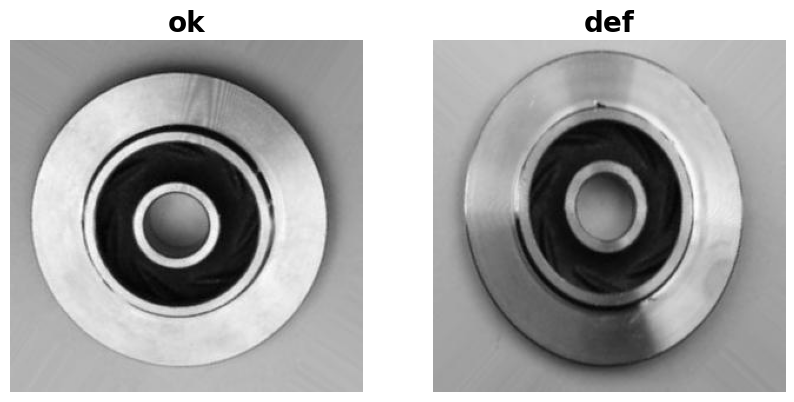

In [3]:
plt.figure(figsize=(10,8))
ok = plt.imread(train_path + 'ok_front/cast_ok_0_1.jpeg')
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("ok", weight='bold', size=20)
plt.imshow(ok,cmap='gray')

ng = plt.imread(train_path + 'def_front/cast_def_0_1001.jpeg')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("def", weight='bold', size=20)
plt.imshow(ng,cmap='gray')

plt.show()

# Preprocessnig
When training with image data without data augmentation, we only need to specify the amount of data and create a mini-batch. When performing data augmentation, after the data is acquired, various augmentation techniques are applied to the images to create new mini-batches.
The main parameters of data enhancement technology (Keras ImageDataGenerator) are as follows:

- rotation_range : rotate the image (e.g. 50 -> rotate randomly in the range -50°~50°)
- Zoom_range : Zoom in/out the image (eg 0.5 -> 1-0.5~1+0.5 random zoom in/out)
- Brightness_range : change brightness (e.g. [0.3,1.0] -> change randomly in [0.3,1.0])
- Vertical_flip : flip the image upside down
- Horizontal_flip : flips the image left or right
- height_shift_range : shift image up or down in parallel (e.g. 0.3 -> random up/down in [-0.3*Height, 0.3*Height] )
- width_shift_range : Shift image left or right in parallel (e.g. 0.3 -> shift left/right randomly in [-0.3*Width, 0.3*Width] )
- rescale : Normalizes the image by multiplying each pixel value by a constant. (e.g. 1/255 -> normalize each pixel's RGB value between 0.0 and 1.0)

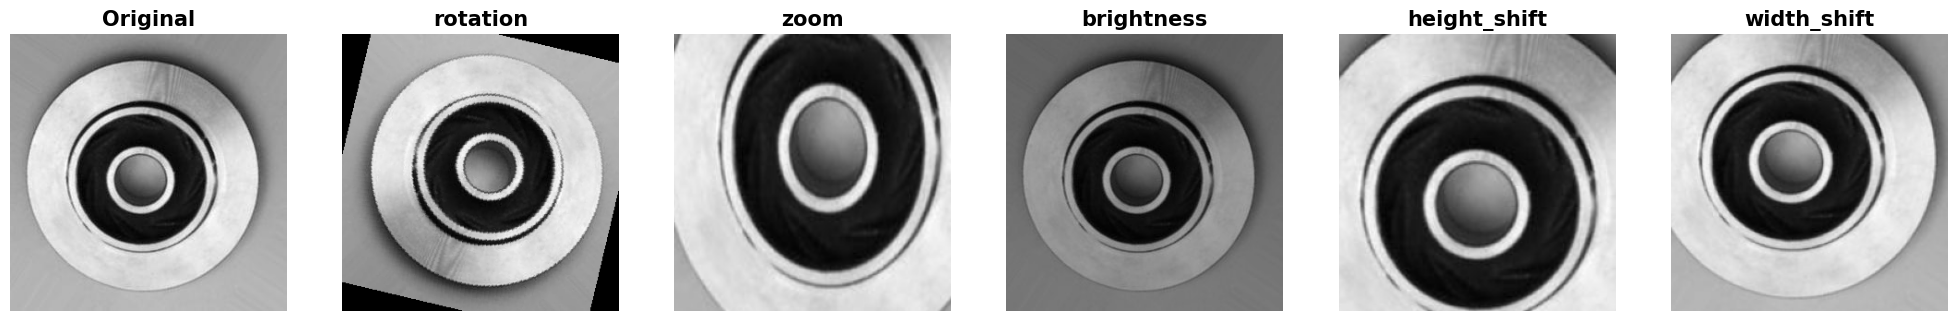

In [4]:
## take a look at the augmented data
# Read the image
img = cv2.imread(train_path + 'ok_front/cast_ok_0_1.jpeg')  # load data
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV读取的是BGR格式，转换为RGB格式

# Initialize the plot
plt.figure(figsize=(25, 10))

# Original Image
plt.subplot(1, 6, 1)
plt.title("Original", weight='bold', size=15)
plt.imshow(img)
plt.axis('off')

# Define transformations (augmentations)
generators = {
    "rotation": transforms.RandomRotation(180),
    "zoom": transforms.RandomResizedCrop(224, scale=(0.3, 1.0)),
    "brightness": transforms.ColorJitter(brightness=[0.2, 1.0]),
    "height_shift": transforms.RandomResizedCrop(224, scale=(0.3, 1.0), ratio=(0.5, 1.5)),
    "width_shift": transforms.RandomResizedCrop(224, scale=(0.3, 1.0), ratio=(0.5, 1.5))
}

cnt = 2
for param, transform in generators.items():
    pil_img = Image.fromarray(img)
    transformed_img = transform(pil_img)
    transformed_img_np = np.array(transformed_img)

    plt.subplot(1, 6, cnt)
    plt.title(param, weight='bold', size=15)
    plt.imshow(transformed_img_np)
    plt.axis('off')
    cnt += 1

# Show plot
plt.show()


In [5]:
## create dataload with data augmentation 
# Set parameters
image_shape = (300, 300)
batch_size = 32

# Image transformations
transform = transforms.Compose([
    transforms.Resize(image_shape),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=[0.9, 1.0]),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Rescale to [0, 1]
])

# Create train and validation loader

dataset = datasets.ImageFolder(train_path, transform=transform, 
                                     is_valid_file=lambda x: x.endswith('.jpeg'))  # Or any other image extension you're using

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
# create test loader

test_dataset = datasets.ImageFolder(test_path, transform=transform, 
                                    is_valid_file=lambda x: x.endswith('.jpeg'))  # Or any other image extension you're using
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Set class mappings manually
train_dataset.class_to_idx = {'def_front': 0, 'ok_front': 1}
test_dataset.class_to_idx = {'def_front': 0, 'ok_front': 1}


To simply the process, we use the same transformation for both test set and train set

# Modelling
增加对模型的介绍
## simple cnn

In [6]:


class SimpleCNN(nn.Module):
    def __init__(self, image_shape):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(image_shape[2], 16, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #self.fc1 = nn.Linear(64 * (image_shape[0] // 8) * (image_shape[1] // 8), 224)
        self.fc1 = nn.Linear(20736, 224) # magic number
        self.fc2 = nn.Linear(224, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        #x = self.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x

# Create the model
image_shape = (300, 300, 1)  # H x W x C
model = SimpleCNN(image_shape)

# Loss and optimizer
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Display model architecture
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=20736, out_features=224, bias=True)
  (fc2): Linear(in_features=224, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [7]:
# # Create a dummy input that matches the input dimensions of the model
# # Assuming the model expects (batch_size, channels, height, width)
# dummy_input = torch.randn(1, 1, 300, 300)  # Here, batch_size = 1, channels (grayscale) = 1, height = 300, width = 300

# # Make sure your model is on the same device as the dummy input
# model = model.to('cpu') 

# # Forward pass with dummy input
# output = model(dummy_input)

# # Visualize the computational graph
# dot = make_dot(output, params=dict(model.named_parameters()))
# dot.render("model_graph", format="png", cleanup=True)

class EarlyStopping:
    def __init__(self, patience=2, out_path = 'casting_product_detection.pth', verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.out_path = out_path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.out_path)
        self.val_loss_min = val_loss

def validate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= total
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return val_loss, accuracy, f1

# Initialize early stopping and model checkpoint
early_stopping = EarlyStopping(patience=2, verbose=True)

n_epochs = 20
model_history = {'loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader):
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(outputs.shape, outputs)
        #loss = criterion(outputs.squeeze(1), labels.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    model_history['loss'].append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_loss, accuracy, f1 = validate(model, val_loader)
    
    model_history['val_loss'].append(val_loss)
    model_history['val_acc'].append(accuracy)
    model_history['val_f1'].append(f1)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Acc: {accuracy}, F1: {f1}')

    # Early stopping and model checkpointing
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Save model history to JSON
with open('model_history.json', 'w') as f:
    json.dump(model_history, f, indent=4)


  7%|▋         | 12/166 [00:07<01:31,  1.69it/s]


KeyboardInterrupt: 

In [ ]:
losses = pd.DataFrame(model_history)
losses.index = map(lambda x : x+1, losses.index)
losses.tail(3)

In [ ]:
validate(model, test_loader)

We can see that the performance of the model on the test set is 99%.

However, does this assume that we can use models with confidence. 

To illustrate the need for an explanation, take the example of the one-strike failure of a U.S. missile not long ago


# Intepretation
## TODO: to explain what is XAI, what they can do, why they are important and how it works in this example


In [215]:
# 选择一个图像样本
image = Image.open(train_path + 'def_front/cast_def_0_1001.jpeg')
#image = Image.open(train_path + 'ok_front/cast_ok_0_1019.jpeg')

In [216]:
model.load_state_dict(torch.load('casting_product_detection.pth'))

<All keys matched successfully>

In [217]:
## define prediction function
def predict_fn(images, with_data = False):
    model.eval()
    image_shape = [300, 300]
    transform_test = transforms.Compose([
        transforms.Resize(image_shape),
        transforms.ToTensor(),
        #transforms.Normalize((0.5,), (0.5,)),  # Rescale to [0, 1]
        transforms.Normalize((0.,), (1,)),
    ])
    # transform_test = transforms.Compose([
    #     transforms.Resize(image_shape),
    #     transforms.Grayscale(num_output_channels=1),
    #     transforms.RandomAffine(0, translate=(0.1, 0.1)),
    #     transforms.ColorJitter(brightness=[0.9, 1.0]),
    #     transforms.ToTensor(),
    #     transforms.Normalize((0.5,), (0.5,)),  # Rescale to [0, 1]
    # ])

    
    #|print(image.shape)
    #batch = transform_test(Image.fromarray(image, 'RGB').convert('L')).unsqueeze(dim = 0)
    if len(images.shape) == 3:
        images = np.expand_dims(images, axis = 0)
    batch = torch.stack(tuple(transform_test(Image.fromarray(image, 'RGB').convert('L')) for image in images), dim=0)
    with torch.no_grad():
        outputs = model(batch)
        probabilities = torch.softmax(outputs, dim=1)

    if with_data:
        return probabilities.cpu().numpy(), batch
    return probabilities.cpu().numpy()

In [218]:
predict_fn(np.array(image.convert("RGB")))

array([[0.74668276, 0.25331727]], dtype=float32)

In [219]:
# 初始化 LIME 解释器
explainer = lime_image.LimeImageExplainer()

# 定义图像分割算法
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

# 获取解释
explanation = explainer.explain_instance(
    np.array(image.convert("RGB")), 
    classifier_fn=predict_fn, 
    segmentation_fn=segmenter
)

# 展示解释
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]

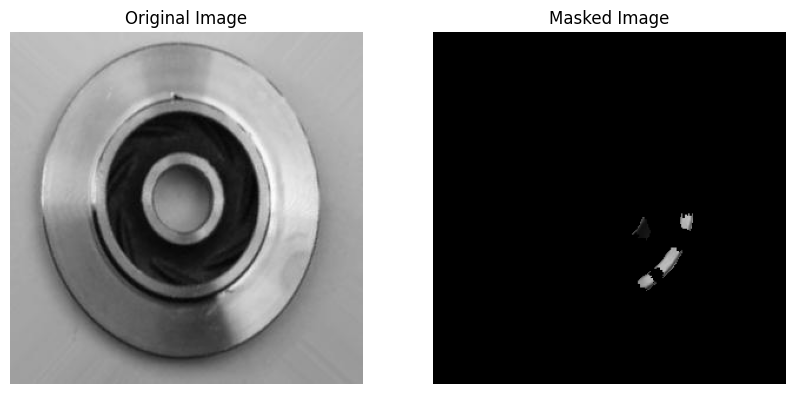

In [220]:
# 将掩码应用到原始图像上
original_image = np.array(image.convert("RGB"))

masked_image = np.zeros_like(original_image)
for i in range(3):
    masked_image[:,:,i] = original_image[:,:,i] * mask

# 显示原始图像和带掩码的图像
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Masked Image')
plt.imshow(masked_image)
plt.axis('off')

plt.show()

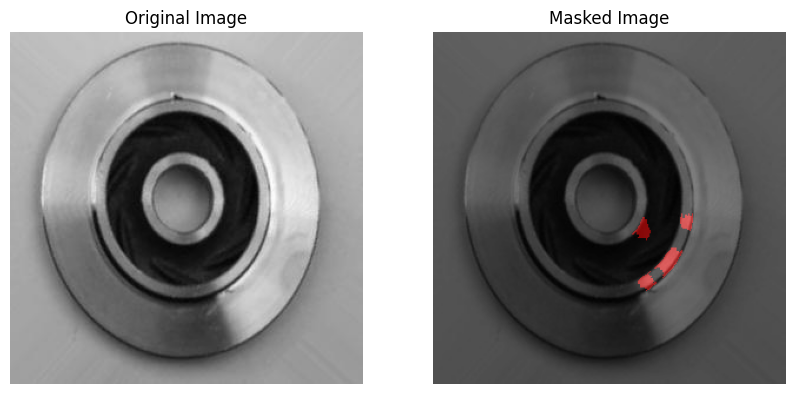

In [221]:
# 创建一个与原始图像大小相同的全红色图像
overlay = np.zeros_like(original_image)
overlay[:,:,0] = 255  # 红色通道

# 将掩码应用到覆盖层上，使其半透明
masked_overlay = np.zeros_like(original_image)
for i in range(3):  # 对于 RGB 的每一个通道
    masked_overlay[:,:,i] = overlay[:,:,i] * mask

# 将半透明的覆盖层添加到原始图像上
masked_image = original_image.copy()
alpha = 0.5  # 设置透明度
masked_image = cv2.addWeighted(masked_image, 1 - alpha, masked_overlay, alpha, 0)

# 显示原始图像和带有标记的图像
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Masked Image')
plt.imshow(masked_image)
plt.axis('off')

plt.show()


The image above show the result of the most popular explainable AI technique: LIME. We can see that the explaination is not coordenate to our institute. To figure out whether it's due to the model or XAI technique. we compare the result before and after the mask.

In [225]:
print(f'The prediction certainty value on the original model is: {predict_fn(original_image)}')

The prediction certainty value on the original model is: [[0.74668276 0.25331727]]


In [228]:
masked_image = original_image.copy()
alpha = 1  # 设置透明度
masked_image = cv2.addWeighted(masked_image, 1 - alpha, masked_overlay, alpha, 0)
print(f'The prediction certainty value on the masked model is: {predict_fn(masked_image)}')

The prediction certainty value on the masked model is: [[0.9422546  0.05774547]]


We can see that, the certainty improved after the masking, wich is different from the anouncement of the LIME method. Which means that the XAI method itself work poor on this case. To this end, we proposed a new method for XAI method. Let's have a look at it's explaination results:

In [229]:
import sys
sys.path.append('./src/')
import logging
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
#logger.setLevel(logging.INFO)
logger.setLevel(logging.WARNING)

In [230]:
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
from skimage import io
from tqdm import tqdm

from mcxai.agent import Two_Player_Minus_Agent
from mcxai.state import State
from mcxai.game import Two_Player_Minus_Game

In [231]:
fsize = 300
ksize = int(fsize/2)
#start = 8
c = .5 # math.sqrt(2)
threshold = 0.5
threshold2 = threshold/2

we use the same image as before

In [236]:
image = Image.open(train_path + 'def_front/cast_def_0_1001.jpeg')
image = np.array(image.convert("RGB"))

In [237]:
#image = torch.from_numpy(image).permute(2,0,1)[0:1,:,:]

In [238]:
acc, processed_image = predict_fn(image, with_data = True)
acc

array([[0.74668276, 0.25331727]], dtype=float32)

In [239]:
target = 0

In [240]:
#data, target = dataset[3]
data = processed_image[0]
game = Two_Player_Minus_Game(data, model, target=target, fsize=fsize, ksize=ksize, threshold= threshold, threshold2 = threshold2, logger = logger)
agent = Two_Player_Minus_Agent(game, c=c, logger = logger)
node, node2, path, path2 = agent.run_sequential()
tmp = [data, target, node, node2, path, path2]
with open('result_mcxai.pkl', 'wb') as output:
    pickle.dump(tmp, output, pickle.HIGHEST_PROTOCOL)


- Start to tain agent, with:
    c: 0.5
    max_depth: 4
    fsize: 300
    Original ksize: 150
    number actions: 4
Initial performance for player 0 is 0.7466827630996704
---------------------------------------------------------------------------------
The current ksize is 150
- Run first level episode


  0%|          | 0/32 [00:00<?, ?it/s]

+ End with first level
Parent performance: 0.7466827630996704
N: [1, 1, 1, 2]
Performance: [tensor(0.7447), tensor(0.6989), tensor(-0.0752), tensor(0.7460)]
Winrate: [0, 0, 0, tensor(1.)]
Part2: [0, 0, 0, 0.5887050112577373]
Value: [tensor(1.1610), tensor(1.1152), tensor(0.3410), tensor(1.2944)]
Empty DataFrame
Columns: [0, 1, 2, 3]
Index: []
- Choose action that need to refine, with the winrate selection
+ End with action selection, list length: 1
old size: 150, new size: 75, ratio: 2
- Refine grid to the chosen actions, the size of the original grid is 150


+ Finish refining, new grid size is: 75, length of generated list_action is: 1
---------------------------------------------------------------------------------
The current ksize is 75
- Run lower level episode, the length of list_actions is 1
    process the 0th item in the list_actions
    - Performance of the new root mask is 0.7466827630996704
    - Size of action space is 4
    - Sum of the new root mask is 90000.0
    - Start to build tree


  3%|▎         | 1/32 [00:00<00:03,  9.71it/s]

    - End with tree generation
Parent performance: 0.7466827630996704
N: [3, 1, 1, 1]
Performance: [tensor(0.2242), tensor(-0.2484), tensor(-0.2002), tensor(0.1819)]
Winrate: [tensor(0.6250), 0, 0, 0]
Part2: [0.6051479953058616, 0, 0, 0]
Value: [tensor(0.9276), tensor(0.2757), tensor(0.3238), tensor(0.7059)]
Empty DataFrame
Columns: [0, 1, 2, 3]
Index: []
- Choose action that need to refine, with the winrate selection
+ End with action selection, list length: 2
old size: 75, new size: 38, ratio: 2
- Refine grid to the chosen actions, the size of the original grid is 75


+ Finish refining, new grid size is: 38, length of generated list_action is: 2
-----------------
---------------------------------------------------------------------------------
The current ksize is 38
- Run lower level episode, the length of list_actions is 2
    process the 1th item in the list_actions
    - Performance of the new root mask is 0.6547315716743469
    - Size of action space is 4
    - Sum of the new root mask is 84224.0
    - Start to build tree


  0%|          | 0/32 [00:00<?, ?it/s]

    - End with tree generation
Parent performance: 0.6547315716743469
N: [1, 2, 1, 1]
Performance: [tensor(0.1348), tensor(0.1724), tensor(-0.0018), tensor(-0.0622)]
Winrate: [0, tensor(1.), 0, 0]
Part2: [0, 0.5887050112577373, 0, 0]
Value: [tensor(0.5511), tensor(1.2944), tensor(0.4145), tensor(0.3541)]
Empty DataFrame
Columns: [0, 1, 2, 3]
Index: []
- Choose action that need to refine, with the winrate selection
+ End with action selection, list length: 1
old size: 38, new size: 19, ratio: 2
- Refine grid to the chosen actions, the size of the original grid is 38


+ Finish refining, new grid size is: 19, length of generated list_action is: 1
-----------------
    process the 0th item in the list_actions
    - Performance of the new root mask is 0.9015428423881531
    - Size of action space is 4
    - Sum of the new root mask is 88556.0
    - Start to build tree


  3%|▎         | 1/32 [00:00<00:03, 10.09it/s]

    - End with tree generation
Parent performance: 0.9015428423881531
N: [1, 1, 1, 3]
Performance: [tensor(-0.0393), tensor(0.0363), tensor(0.0939), tensor(0.1453)]
Winrate: [0, 0, 0, tensor(0.6250)]
Part2: [0, 0, 0, 0.6051479953058616]
Value: [tensor(0.4848), tensor(0.5603), tensor(0.6180), tensor(0.9276)]
Empty DataFrame
Columns: [0, 1, 2, 3]
Index: []
- Choose action that need to refine, with the winrate selection
+ End with action selection, list length: 2
old size: 38, new size: 19, ratio: 2
- Refine grid to the chosen actions, the size of the original grid is 38


+ Finish refining, new grid size is: 19, length of generated list_action is: 2
-----------------
+ Size is 19 End with seed selection, all factor explored
+ End with lower level episode
Final Round:
    - Performance of the new root mask is 0.7466827630996704
    - Size of action space is 12
    - Sum of the new root mask is 90000.0
    - Start to build tree


100%|██████████| 300/300 [00:33<00:00,  9.01it/s]


    - End with tree generation
Parent performance: 0.7466827630996704
N: [25, 27, 27, 27, 25, 26, 25, 27, 27, 25, 26, 25]
Performance: [tensor(0.0659), tensor(-0.1130), tensor(-0.1045), tensor(-0.1280), tensor(-0.0114), tensor(0.0772), tensor(-0.0205), tensor(-0.0652), tensor(-0.1301), tensor(-0.0329), tensor(-0.0628), tensor(-0.0267)]
Winrate: [tensor(0.3819), tensor(0.3910), tensor(0.3910), tensor(0.3910), tensor(0.3819), tensor(0.3867), tensor(0.3819), tensor(0.3910), tensor(0.3910), tensor(0.3819), tensor(0.3867), tensor(0.3819)]
Part2: [0.4777911788532256, 0.4597547762122307, 0.4597547762122307, 0.4597547762122307, 0.4777911788532256, 0.46851279699905723, 0.4777911788532256, 0.4597547762122307, 0.4597547762122307, 0.4777911788532256, 0.46851279699905723, 0.4777911788532256]
Value: [tensor(0.6208), tensor(0.6209), tensor(0.6209), tensor(0.6209), tensor(0.6208), tensor(0.6209), tensor(0.6208), tensor(0.6209), tensor(0.6209), tensor(0.6208), tensor(0.6209), tensor(0.6208)]
Empty Data

In [241]:
agent.get_results()

(<mcxai.mct.MC_node at 0x1472d3084ca0>,
  <mcxai.mct.MC_edge at 0x1472d3084550>])

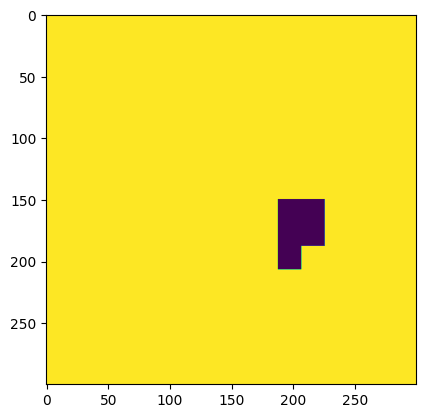

In [242]:
# get the mask
edge = agent.get_results()[1][-1]
node = edge.get_out_node()
plt.imshow(node.get_state().state)

In [243]:
mask = node.get_state().state.numpy()

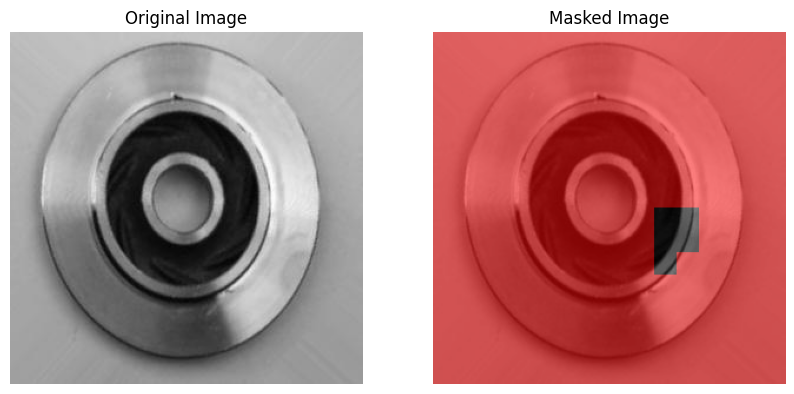

In [250]:
# apply mask to the data
# 创建一个与原始图像大小相同的全红色图像
data = image#.permute(1,2,0).numpy()
overlay = np.zeros_like(data)
overlay[:,:,0] = 255  # 红色通道

# 将掩码应用到覆盖层上，使其半透明
masked_overlay = np.zeros_like(data)
for i in range(3):  # 对于 RGB 的每一个通道
    masked_overlay[:,:,i] = overlay[:,:,i] * mask

# 将半透明的覆盖层添加到原始图像上
masked_image = data.copy()
alpha = 0.5  # 设置透明度
masked_image = cv2.addWeighted(data, 1 - alpha, masked_overlay, alpha, 0)

# 显示原始图像和带有标记的图像
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(data)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Masked Image')
plt.imshow(masked_image)
plt.axis('off')

plt.show()


In [251]:
predict_fn(image)

array([[0.74668276, 0.25331727]], dtype=float32)

to demonstrate the change, we set the tranparent rate to 0.5. to test the masked performance, we set it back to 1.

In [252]:
masked_image = data.copy()
alpha = 1  # 设置透明度
masked_image = cv2.addWeighted(data, 1 - alpha, masked_overlay, alpha, 0)
predict_fn(masked_image)

array([[0.45915896, 0.54084104]], dtype=float32)

We can see that the explaination of the proposed method is also different from our intuitiveness. However, with masking the model predction certainty decrease to smaller then 0.5, which means the change of the model prediction. It prove that the explaination faithful to the model. From this result, two points are extracted:
1. Although the model performance achieve 98%. The reasons for modeling decisions are different than we think. This shows that the accuracy of the model does not tell the whole story.
2. General explaination methods are not suitale for all situation. Popular methods are not guaranteed to be useful in all scenarios. For this reason, we propose a new interpretation method. This method is more faithful to the given model.